# Assignment 4: Permutation test 1
## Learning Outcomes
By completing this assignment, you will be able to implement and use randomization tests to determine whether a specific effect is statistically significant. Randomization tests are a highly universal and powerful way to do this, and form an essential part of the toolkit of any Data Scientist. 

## Problem Description
An increasingly common statistical tool for determining whether a difference is significant is the randomization or permutation test. A randomization test builds - rather than assumes – a sampling distribution of the test statistics. This is achieved by exchanging or permuting variables which are “exchangeable” under the Null-hypothesis. A randomization test gives a simple way to compute the sampling distribution for any test statistic under the null hypothesis that the dependent variable is statistically not dependent on the shuffled variable. 
In this assignment, we continue with the income dataset from week 1 and 2. This week your main task is to determine whether the difference in proportion for female vs. male directors to direct action movies is significant. 
You are allowed to use standard numpy and pandas functions such as mean, groupby, shuffle. But you are not allowed to use a permutation functions that have been already been designed. Numeric calculations in python that are printed should be rounded to 6 decimal places. 

Methods that you may find beneficial. 
Pandas: crosstab, iloc. Numpy: random.shuffle, reset_index, matplotlib: hist, axvline 

## Tbe dataset 
As a data scientist for a Hollywood law firm, your task is to provide evidence for the claim there is gender discrimination on the movie industry. You are provided with a summary of the last 250 movies, and the gender and income of the director. The dataset also includes a number of other variables
- North American box office revenue (boxoff)
- Production cost of the movie (prodcost)
- Income of the director (dirIncome in millions)
- Gender of the director (dirGender) 
- Year of release (year)
- Month of release (month) 
- Movie genre (genre): Action, Comedy 
- Number of theatres (numTheatrs)


## Preliminaries 
Import pandas, numpy, matplotlib, and load the dataset file

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv('movieDataset.csv')
df.head()

,boxoff,prodcost,dirIncome,dirGender,year,month,genre,numTheatres
0,88.648583,44.742936,1.143234,male,2012,3,comedy,139
1,145.334924,38.835516,3.393535,female,2014,11,drama,213
2,238.265684,29.532283,2.418883,male,2015,6,other,100
3,212.714742,157.111899,2.034115,male,2014,10,adventure,436
4,120.175461,30.547155,0.963219,female,2012,1,comedy,115


## TASK 1: Defining the test statistics (40pts)
### Question 1  - Explore the gender imbalance across movie genres (10pts)
As you did in Assignment 02, create a table that displays the number of movies per genre and director gender. Make a stacked barplot that best let's you see what proprtion of directors were female for each movie genre.   Remember x-, y-axis labels and caption. Written answer: Which movie genre has the highest proportion of female directors? 

*Hint: Since this is a new dataset for you, it is excellent practice to explore the dataset as you did in Assignment number 2*

In [2]:
table_2 = pd.crosstab(df.genre, df.dirGender)
table_2

dirGender,female,male
genre,,
action,9,48
adventure,6,58
comedy,13,35
drama,5,31
other,4,41


dirGender    female      male
genre                        
action     0.157895  0.842105
adventure  0.093750  0.906250
comedy     0.270833  0.729167
drama      0.138889  0.861111
other      0.088889  0.911111


Text(0, 0.5, 'Probability')

<Figure size 640x480 with 0 Axes>

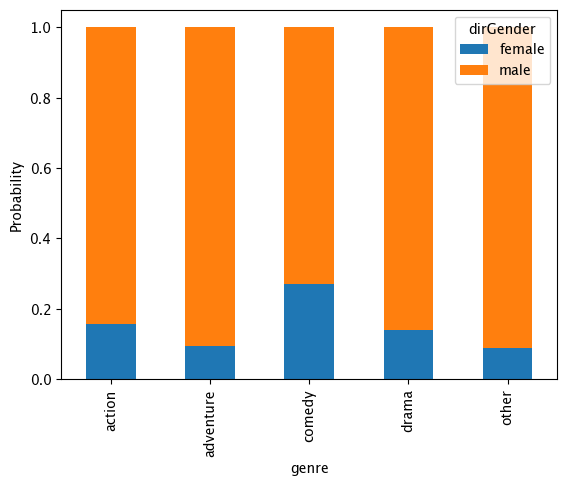

In [3]:
table = pd.crosstab(df.genre, df.dirGender, normalize = 'index') #setting normalize option equal to 'index' will normalize over each row
print(table)
fig4  = plt.figure()
ax = table.plot(kind = 'bar', stacked = True)
ax.set_ylabel('Probability')

Figure 1. Proportion of female (blue) and male (red) directors depending on the genre of the movie. 

The proportion of female director appears to be highest for the comedy genre. 

### Question 2 - Create contingency table of comedy (yes/no) by director gender (5pts)
Generate and display a cross-tabulation table of the 2x2 proportions of directorGender vs. whether the movie is a comedy or not (all other genres should be combined into non-comedy movies).  

In [4]:
ctab = pd.crosstab(df['genre'] == 'comedy', df['dirGender'], margins = True)
ctab

dirGender,female,male,All
genre,,,
False,24,178,202
True,13,35,48
All,37,213,250


In [5]:
ctab_2 = pd.crosstab(df['genre'] == 'comedy', df['dirGender'], margins = False, normalize = 'columns')
ctab_2

dirGender,female,male
genre,,
False,0.648649,0.835681
True,0.351351,0.164319


### Question 2 - Calculate p(comedy|female)-p(comedy|male) (15pts)
Calculate and report the probability that the movie is a comedy given that the director Gender is female, p(comedy|female), the probability of the movie is a comedy given that the director Gender is male, p(comedy|male), as well as the difference between these two numbers, p(comedy|female)- p(comedy|male) (for help, see solution to homework 2).

In [6]:
p_com_fem = ctab['female'][True]/ctab['female']['All']
print(f"p(comedy|female) = {p_com_fem}")

p(comedy|female) = 0.35135135135135137


In [7]:
p_com_m = ctab['male'][True]/ctab['male']['All']
print(f"p(comedy|male) = {p_com_m}")

p(comedy|male) = 0.1643192488262911


In [8]:
p_diff = p_com_fem - p_com_m
print(f"The difference between p(comedy|female) and p(comedy|male) is {p_diff}")

The difference between p(comedy|female) and p(comedy|male) is 0.18703210252506028


### Question 3 - Define a function that calculates this difference in probability (10pts)
Write a function (e.g., https://www.tutorialspoint.com/python/python_functions.htm) that takes the data frame as an input and returns the difference on conditional probabilities (as calculated in question 2). 
Test the function by calling it with your data and report the difference in probability 
This difference is your test statistics for the coming permutation test.

In [9]:
def prob_diff(data):

    # generate the contingency table
    tab = pd.crosstab(data['genre'] == 'comedy', data['dirGender'], margins = True)

    # calculate the difference
    p_diff = (tab['female'][True]/tab['female']['All']) - (tab['male'][True]/tab['male']['All'])

    return p_diff

In [10]:
empDiff = prob_diff(df)
print(f"The difference between p(comedy|female) and p(comedy|male) is {empDiff}")

The difference between p(comedy|female) and p(comedy|male) is 0.18703210252506028


## Task 2: Perform a permutation test (60pts)
### Question 1 (10pts)
Written answer: We want to test the hypothesis that female directors are more likely than male directors to conduct a comedy. Under this hypothesis the p(comedy|female) should be higher than p(comedy|male). What is the Null-hypothesis we need to consider? 

>The Null-hypothesis is that p(comedy|female) is equal or lower than p(comedy|male)

>H0: P (comedy | female) <= p(comedy|male)

### Question 2 (40pts)
Perform a permutation test. Under the Null-hypothesis the director gender is exchangeable. 

First, write a function that takes a data frame as an input, and then randomly permutes a specific column of that that data frame (see lab for hints). The function should then return a modified copy of the dataframe.

Then write a function ``permutation_test`` that takes a data frame as an input and the loops ``numIter`` times. Every iteration of the  the loop it should shuffle the dirGender column of the data and then calls the function written for Task1, Q3 to get the test statistic. Each iteration, the test statistic should  be stored in a list.  

After building up the numpy array of test statistics, the function should plot a histogram of the test statistics and mark the value of the empirical test statistics by a vertical line (see https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.axvline.html). Finally, it should report the p-value. 

For Pseudo code see lecture. Start with 500 iterations to test your code – for the final result, use 5000 iterations.

In [11]:
# Write a little function that shuffels the column
# of one single variable. We need to be carful here,
# as the functions get the data frame as an object
def randomize_column (df,colname):
    df_copy = df.copy()
    var = df_copy[colname].values
    np.random.shuffle(var)
    df_copy[colname]=var
    return df_copy

def permutation_test(data):

    # shuffle = 'dirGender'
    numIter = 5000

    stat = np.zeros(numIter, dtype = 'float64') # initialize the numpy array that will store the test stat

    ## 1. shuffling the "exchangeable" variable
    i = 0 # iteration variable
    while i < numIter:

        ## permute (shuffle) the exchangeable variable
        tmpDF = randomize_column(df,'dirGender')

        ## calculate the test stat.
        stat[i] = prob_diff(tmpDF)
        i += 1

    ## 2. plotting the histogram of the test statistic
    plt.figure()
    plt.hist(stat, bins = 10)
    empStat = prob_diff(data)
    plt.axvline(x = empStat, color = 'r')

    plt.show()

    ## 3. calculating the p-value (one-sided)
    p_value = sum(stat >= empStat)/len(stat)

    print('P-value of the randomisation test is p=',p_value)

    return p_value

# The following code will also work
# def performPermutation(D):
#     numIterations = 5000 #10000 iterations
#     shuffle = 'directorGender'
#     testStats = 'prob_diff'

#     listOfTS =  np.array(range(numIterations),dtype = 'float64')
#     for i in range(numIterations):
#         #1. Randomly shuffle the data
#         S=D.copy()                    # Make copy of the data frame
#         x = np.array(range(len(D.index))) # Make copy of the data frame
#         np.random.shuffle(x)          # randomly shuffle x - note that this changes x itself!
#         y = S.dirGender.iloc[x]   # copy the newly reorded values into a new Series
#         y = y.reset_index(drop=True)   #reoder the indices
#         S.dirGender=y           # Copy back into the data frame

#         #2. Calculate test statistics
#         listOfTS[i] = prob_diff(S)

#     # 3. Caluclate the real test statistic
#     realTS = prob_diff(D)

#     # 4. Plot a histogram of the
#     plt.hist(listOfTS,bins=10)
#     plt.axvline(x=realTS, color='k')

#     # 5. determine p-value (one sided)
#     p=sum(listOfTS>=realTS)/len(listOfTS)
#     print('P-value of the randomisation test is p=',p)
#     return p

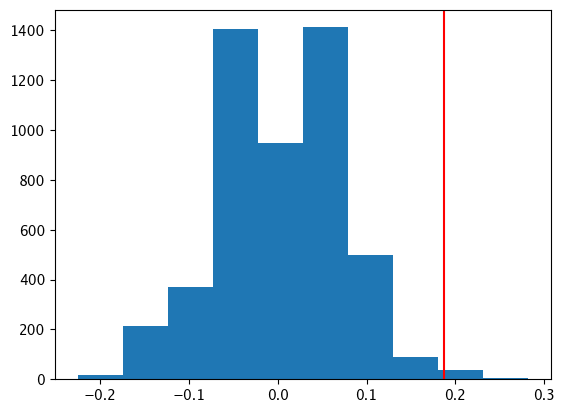

P-value of the randomisation test is p= 0.0086


In [12]:
p = permutation_test(df)

### Question 3 (10pts)
Written response: What do you conclude from this result?


>Answer: Based on these results (P-val < 0.05) we reject the null hypothesis. Thus, there is statistical significance for the alternative hypothesis that female directors are more likely to direct a comedy than male directors. 